# PCA & Clustering of Fe K-edge µ-XANES Spectra

This notebook performs principal component analysis (PCA) and k-means clustering on
pre-normalized Fe K-edge µ-XANES spectra to identify distinct spectral groups.

**Workflow:**
1. Load flattened/normalized spectra from CSV files
2. Build a spectral matrix interpolated onto a common energy grid
3. Screen for outlier spectra (distance from mean)
4. Run PCA to determine the number of significant components
5. Cluster spectra in PC-score space using k-means
6. Inspect clusters and export assignments

**Inputs:** `flattened-spectra/*.csv` — individual normalized XANES spectra

**Outputs:** `pca_results/` — cluster assignments, PCA diagnostics, score scatter plots

## Imports and configuration

In [1]:
"""
XAS Spectra PCA + Clustering Pipeline
======================================
Reads pre-normalized XANES/EXAFS spectra, performs PCA to identify
the number of distinct spectral components, then clusters spectra
in PC-score space to group similar grains.

Assumes spectra are already normalized/flattened (e.g., via Athena or Larch).
Uses the flattened (post-edge-corrected) XANES by default to avoid
post-edge slope artifacts in PCA.

Requirements:
    pip install xraylarch scikit-learn scipy matplotlib numpy pandas

Usage:
    1. Update the CONFIGURATION section below with your paths and parameters.
    2. Run: python xas_pca_clustering.py
"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from pathlib import Path
import pandas as pd

# Larch imports
from larch import Group
from larch.math import pca_train

In [2]:
# ============================================================
# CONFIGURATION
# ============================================================

# Directory containing your normalized spectra files
SPECTRA_DIR = Path("./flattened-spectra")

# Energy range to use for PCA (eV, relative to E0 or absolute)
# Set to None to use the full overlapping range
E_MIN = 7100  # e.g., -20 (relative to E0) or 7100 (absolute)
E_MAX = 7180  # e.g., 80 (relative to E0) or 7200 (absolute)
ENERGY_IS_RELATIVE = False  # True if E_MIN/E_MAX are relative to E0

# PCA region: 'xanes' uses normalized mu(E), 'exafs' uses chi(k)
PCA_REGION = "xanes"

# Common energy/k grid spacing for interpolation
E_STEP = 0.2  # eV step for XANES

# Max number of clusters to evaluate
MAX_CLUSTERS = 15

# Set to None to use silhouette-optimal k, or an integer to override
FORCE_K = 5

# Number of PCA components to use for clustering and target transformation.
# Set to None to use the IND minimum (automatic), or override with an integer
# if IND gives an unreasonable result (common with noisy microprobe data).
N_COMPONENTS = 5

# Reference spectra for target transformation (optional)
# List of file paths to reference spectra
REFERENCE_DIR = Path("./FeK-standards/fluorescence/flattened")
REFERENCE_FILES = ["2L-Fhy on sand.csv",
                    "2L-Fhy.csv",
                    "6L-Fhy.csv",
                    "Augite.csv",
                    "Biotite.csv",
                    "FeS.csv",
                    "Ferrosmectite.csv",
                    "Goethite on sand.csv",
                    "Goethite.csv",
                    "Green Rust - Carbonate.csv",
                    "Green Rust - Chloride.csv",
                    "Green Rust - Sulfate.csv",
                    "Hematite on sand.csv",
                    "Hematite.csv",
                    "Hornblende.csv",
                    "Ilmenite.csv",
                    "Jarosite.csv",
                    "Lepidocrocite.csv",
                    "Mackinawite (aged).csv",
                    "Mackinawite.csv",
                    "Maghemite.csv",
                    "Nontronite.csv",
                    "Pyrite.csv",
                    "Pyrrhotite.csv",
                    "Schwertmannite.csv",
                    "Siderite-n.csv",
                    "Siderite-s.csv",
                    "Vivianite.csv"] 
                    
REFERENCE_PATHS = [REFERENCE_DIR / f for f in REFERENCE_FILES]
# Output directory

# Bulk directory
BULK_DIR = Path("./bulk")
BULK_PATTERN = '*.csv'

OUTPUT_DIR = Path("./pca_results")

## Data loading

Load pre-normalized spectra from individual CSV files. Each file has two columns:
energy (eV) and flattened µ(E).

In [3]:
def load_ascii_spectra(spectra_dir, pattern="*.csv"):
    """
    Load pre-normalized/flattened spectra from individual CSV files.
    Expected format: comment lines starting with #, then two columns
    (energy, flat) comma-separated.
    """
    groups = []
    files = sorted(Path(spectra_dir).glob(pattern))
    for f in files:
        try:
            data = np.loadtxt(str(f), delimiter=",", comments="#")
            g = Group(
                energy=data[:, 0],
                flat=data[:, 1],
                filename=f.stem,
                _name=f.stem,
            )
            groups.append(g)
        except Exception as e:
            print(f"  Skipping {f.name}: {e}")
    print(f"Loaded {len(groups)} spectra from {spectra_dir}")
    return groups

## Spectral matrix construction

Interpolate all spectra onto a common energy grid for matrix operations.

In [4]:
def build_xanes_matrix(groups, e_min=None, e_max=None):
    """
    Interpolate normalized XANES spectra onto a common energy grid.
    Returns: energy_grid (1D), matrix (n_spectra x n_energy), names list
    """
    # Find the common energy range
    all_emin = max(g.energy.min() for g in groups)
    all_emax = min(g.energy.max() for g in groups)

    if e_min is not None:
        if ENERGY_IS_RELATIVE:
            # Use median E0 as reference
            e0_median = np.median([g.e0 for g in groups])
            all_emin = max(all_emin, e0_median + e_min)
        else:
            all_emin = max(all_emin, e_min)

    if e_max is not None:
        if ENERGY_IS_RELATIVE:
            e0_median = np.median([g.e0 for g in groups])
            all_emax = min(all_emax, e0_median + e_max)
        else:
            all_emax = min(all_emax, e_max)

    energy_grid = np.arange(all_emin, all_emax, E_STEP)
    matrix = np.zeros((len(groups), len(energy_grid)))
    names = []

    for i, g in enumerate(groups):
        matrix[i, :] = np.interp(energy_grid, g.energy, g.flat)
        names.append(g._name)

    print(f"Spectral matrix: {matrix.shape[0]} spectra × {matrix.shape[1]} energy points")
    print(f"Energy range: {energy_grid[0]:.1f} – {energy_grid[-1]:.1f} eV")
    return energy_grid, matrix, names

## Quality screening

Remove spectra that deviate >3σ from the mean spectrum (Euclidean distance in spectral space).

In [5]:
# ============================================================
# QUALITY SCREENING
# ============================================================

def screen_spectra(matrix, names, sigma_threshold=3.0):
    """
    Remove outlier spectra based on their distance from the mean spectrum.
    Returns filtered matrix and names.
    """
    mean_spec = matrix.mean(axis=0)
    distances = np.sqrt(np.sum((matrix - mean_spec) ** 2, axis=1))
    threshold = distances.mean() + sigma_threshold * distances.std()

    mask = distances < threshold
    n_removed = (~mask).sum()
    if n_removed > 0:
        print(f"Quality screen: removed {n_removed} spectra beyond {sigma_threshold}σ")
        removed_names = [names[i] for i in range(len(names)) if not mask[i]]
        for rn in removed_names:
            print(f"    Removed: {rn}")
    else:
        print("Quality screen: all spectra passed")

    filtered_names = [names[i] for i in range(len(names)) if mask[i]]
    return matrix[mask], filtered_names, mask

## PCA

Run PCA using Larch's `pca_train`. The IND (indicator) function identifies the number of
statistically significant components. Diagnostics include scree plot, IND function,
component spectra, and cumulative variance.

In [6]:
# ============================================================
# PCA
# ============================================================

def run_pca(x_grid, matrix, names):
    """
    Run PCA using Larch's pca_train.
    Returns the PCA result group.
    """
    # Build Larch groups for pca_train
    groups_for_pca = []
    for i in range(matrix.shape[0]):
        g = Group()
        if PCA_REGION == "xanes":
            g.energy = x_grid
            g.flat = matrix[i, :]
        else:
            g.k = x_grid
            g.chi = matrix[i, :] / (x_grid ** K_WEIGHT)  # undo k-weight
        g._name = names[i]
        groups_for_pca.append(g)

    if PCA_REGION == "xanes":
        pca_result = pca_train(groups_for_pca, arrayname="flat")
    else:
        pca_result = pca_train(groups_for_pca, arrayname="chi")

    return pca_result


def plot_pca_diagnostics(pca_result, output_dir):
    """Plot scree plot, IND, and component spectra."""
    fig = plt.figure(figsize=(16, 12))
    gs = GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.3)

    n_show = min(20, len(pca_result.variances))

    # --- Scree plot ---
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.semilogy(range(1, n_show + 1), pca_result.variances[:n_show], "ko-")
    ax1.set_xlabel("Component number")
    ax1.set_ylabel("Eigenvalue (variance)")
    ax1.set_title("Scree Plot")
    ax1.set_xticks(range(1, n_show + 1))
    ax1.grid(True, alpha=0.3)

    # --- IND function ---
    ax2 = fig.add_subplot(gs[0, 1])
    ind = pca_result.ind
    ax2.semilogy(range(1, len(ind) + 1), ind, "rs-")
    ind_min = np.argmin(ind) + 1
    ax2.axvline(ind_min, color="blue", linestyle="--", label=f"IND min = {ind_min}")
    ax2.set_xlabel("Component number")
    ax2.set_ylabel("IND")
    ax2.set_title(f"Indicator Function (minimum at {ind_min} components)")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # --- First few component spectra ---
    ax3 = fig.add_subplot(gs[1, 0])
    n_comp_show = min(5, ind_min + 2)
    for i in range(n_comp_show):
        offset = i * 0.5
        ax3.plot(pca_result.components[i] + offset, label=f"PC{i+1}")
    ax3.set_xlabel("Point index")
    ax3.set_ylabel("Component loading (offset)")
    ax3.set_title("Principal Component Spectra")
    ax3.legend(fontsize=8)

    # --- Cumulative variance ---
    ax4 = fig.add_subplot(gs[1, 1])
    cumvar = np.cumsum(pca_result.variances) / np.sum(pca_result.variances) * 100
    ax4.plot(range(1, n_show + 1), cumvar[:n_show], "go-")
    ax4.axhline(95, color="red", linestyle="--", alpha=0.5, label="95%")
    ax4.axhline(99, color="red", linestyle=":", alpha=0.5, label="99%")
    ax4.set_xlabel("Number of components")
    ax4.set_ylabel("Cumulative variance (%)")
    ax4.set_title("Cumulative Variance Explained")
    ax4.legend()
    ax4.set_xticks(range(1, n_show + 1))
    ax4.grid(True, alpha=0.3)

    plt.savefig(output_dir / "pca_diagnostics.png", dpi=150, bbox_inches="tight")
    plt.close()
    print(f"Saved: pca_diagnostics.png")
    return ind_min

## Clustering

Evaluate k-means clustering with silhouette analysis and hierarchical clustering dendrograms.
The optimal k is determined by silhouette score, but can be overridden with `FORCE_K`.

In [7]:
# ============================================================
# CLUSTERING
# ============================================================

def evaluate_kmeans(scores, max_k):
    """Evaluate k-means for different numbers of clusters."""
    results = {"k": [], "inertia": [], "silhouette": []}
    for k in range(2, max_k + 1):
        km = KMeans(n_clusters=k, n_init=20, random_state=42)
        labels = km.fit_predict(scores)
        results["k"].append(k)
        results["inertia"].append(km.inertia_)
        results["silhouette"].append(silhouette_score(scores, labels))
    return results


def run_clustering(scores, names, n_components, output_dir):
    """
    Run k-means and hierarchical clustering on PCA scores.
    Produces diagnostic plots and returns cluster assignments.
    """
    max_k = min(MAX_CLUSTERS, len(names) - 1)

    # --- Evaluate k-means ---
    km_results = evaluate_kmeans(scores, max_k)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Elbow plot
    axes[0].plot(km_results["k"], km_results["inertia"], "ko-")
    axes[0].set_xlabel("Number of clusters (k)")
    axes[0].set_ylabel("Inertia (within-cluster SS)")
    axes[0].set_title("K-Means Elbow Plot")
    axes[0].grid(True, alpha=0.3)

    # Silhouette plot
    axes[1].plot(km_results["k"], km_results["silhouette"], "bs-")
    best_k = km_results["k"][np.argmax(km_results["silhouette"])]
    axes[1].axvline(best_k, color="red", linestyle="--",
                    label=f"Best k = {best_k}")
    axes[1].set_xlabel("Number of clusters (k)")
    axes[1].set_ylabel("Silhouette score")
    axes[1].set_title("Silhouette Analysis")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(output_dir / "kmeans_evaluation.png", dpi=150, bbox_inches="tight")
    plt.close()
    print(f"Saved: kmeans_evaluation.png")
    print(f"Optimal k by silhouette: {best_k}")

    # --- Hierarchical clustering dendrogram ---
    linkage_matrix = linkage(pdist(scores, metric="euclidean"), method="ward")

    fig, ax = plt.subplots(figsize=(16, 8))
    dendrogram(
        linkage_matrix,
        labels=names,
        leaf_rotation=90,
        leaf_font_size=6,
        ax=ax,
    )
    ax.set_title("Hierarchical Clustering Dendrogram (Ward linkage)")
    ax.set_ylabel("Distance")
    plt.tight_layout()
    plt.savefig(output_dir / "dendrogram.png", dpi=150, bbox_inches="tight")
    plt.close()
    print(f"Saved: dendrogram.png")

    # --- Score scatter plots with cluster assignments ---
    km_best = KMeans(n_clusters=best_k, n_init=20, random_state=42)
    labels = km_best.fit_predict(scores)

    n_pairs = min(3, n_components - 1)
    fig, axes = plt.subplots(1, n_pairs, figsize=(6 * n_pairs, 5))
    if n_pairs == 1:
        axes = [axes]

    pc_pairs = [(0, 1), (0, 2), (1, 2)][:n_pairs]
    for ax, (i, j) in zip(axes, pc_pairs):
        scatter = ax.scatter(scores[:, i], scores[:, j], c=labels,
                             cmap="tab10", s=40, edgecolors="k", linewidths=0.5)
        ax.set_xlabel(f"PC{i+1} score")
        ax.set_ylabel(f"PC{j+1} score")
        ax.set_title(f"PC{i+1} vs PC{j+1}")
        ax.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[-1], label="Cluster")
    plt.tight_layout()
    plt.savefig(output_dir / "score_scatter.png", dpi=150, bbox_inches="tight")
    plt.close()
    print(f"Saved: score_scatter.png")

    return labels, best_k, km_best

## Cluster inspection

Plot all spectra within each cluster and overlay cluster centroids.

In [8]:
# ============================================================
# CLUSTER INSPECTION
# ============================================================

def plot_cluster_spectra(x_grid, matrix, names, labels, n_clusters, output_dir):
    """Plot all spectra in each cluster, plus cluster centroids."""
    xlabel = "Energy (eV)" if PCA_REGION == "xanes" else f"k (Å⁻¹)"

    # Individual cluster plots
    fig, axes = plt.subplots(1, n_clusters, figsize=(5 * n_clusters, 5),
                             sharey=True)
    if n_clusters == 1:
        axes = [axes]

    centroids = []
    for ci in range(n_clusters):
        mask = labels == ci
        cluster_spectra = matrix[mask]
        centroid = cluster_spectra.mean(axis=0)
        centroids.append(centroid)
        cluster_names = [names[i] for i in range(len(names)) if mask[i]]

        ax = axes[ci]
        for spec in cluster_spectra:
            ax.plot(x_grid, spec, alpha=0.3, color=f"C{ci}")
        ax.plot(x_grid, centroid, "k-", linewidth=2, label="Centroid")
        ax.set_xlabel(xlabel)
        ax.set_title(f"Cluster {ci+1} (n={mask.sum()})")
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

    axes[0].set_ylabel("Flattened μ(E)" if PCA_REGION == "xanes" else f"k^{K_WEIGHT}·χ(k)")
    plt.tight_layout()
    plt.savefig(output_dir / "cluster_spectra.png", dpi=150, bbox_inches="tight")
    plt.close()
    print(f"Saved: cluster_spectra.png")

    # Overlay of all centroids
    fig, ax = plt.subplots(figsize=(8, 6))
    for ci, centroid in enumerate(centroids):
        ax.plot(x_grid, centroid, label=f"Cluster {ci+1}", linewidth=2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Flattened μ(E)" if PCA_REGION == "xanes" else f"k^{K_WEIGHT}·χ(k)")
    ax.set_title("Cluster Centroids Comparison")
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(output_dir / "cluster_centroids.png", dpi=150, bbox_inches="tight")
    plt.close()
    print(f"Saved: cluster_centroids.png")

    return np.array(centroids)

## Outlier detection

Identify spectra that are far (>2.5σ) from their cluster centroid — potential rare phases or mixed grains.

In [9]:
# ============================================================
# OUTLIER / RARE PHASE DETECTION
# ============================================================

def find_outliers(scores, names, labels, n_sigma=2.5):
    """
    Identify spectra that are far from their cluster centroid.
    These may represent rare phases or mixed grains.
    """
    outliers = []
    for ci in np.unique(labels):
        mask = labels == ci
        cluster_scores = scores[mask]
        centroid = cluster_scores.mean(axis=0)
        distances = np.sqrt(np.sum((cluster_scores - centroid) ** 2, axis=1))
        threshold = distances.mean() + n_sigma * distances.std()

        cluster_names = [names[i] for i in range(len(names)) if mask[i]]
        for idx, (d, name) in enumerate(zip(distances, cluster_names)):
            if d > threshold:
                outliers.append({
                    "name": name,
                    "cluster": ci,
                    "distance": d,
                    "threshold": threshold,
                })

    if outliers:
        print(f"\nPotential outliers / rare phases ({len(outliers)} spectra):")
        for o in outliers:
            print(f"  {o['name']} (cluster {o['cluster']+1}, "
                  f"dist={o['distance']:.3f}, threshold={o['threshold']:.3f})")
    else:
        print("\nNo outliers detected at the current threshold.")

    return outliers

## Export

Save cluster assignments and PC scores to CSV.

In [10]:
# ============================================================
# EXPORT RESULTS
# ============================================================

def export_results(names, labels, scores, n_components, outliers, output_dir):
    """Save cluster assignments and scores to CSV."""
    df = pd.DataFrame({
        "spectrum": names,
        "cluster": labels + 1,  # 1-indexed for readability
    })
    for i in range(n_components):
        df[f"PC{i+1}_score"] = scores[:, i]

    df["is_outlier"] = df["spectrum"].isin([o["name"] for o in outliers])

    outpath = output_dir / "cluster_assignments.csv"
    df.to_csv(outpath, index=False)
    print(f"\nSaved: {outpath}")
    return df

## Helper functions

Utilities for re-clustering with different k and plotting score scatter.

In [11]:
# ============================================================
# HELPER FUNCTIONS FOR INTERACTIVE EXPLORATION
# ============================================================

def override_clusters(scores, k):
    """Re-cluster with a specific k."""
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(scores)
    print(f"Clustered into k={k}:")
    for i in range(k):
        print(f"  Cluster {i+1}: {(labels==i).sum()} spectra")
    return labels, k

def plot_score_scatter(scores, labels, n_components, best_k, output_dir=None, suffix=""):
    """Score scatter plots colored by cluster labels."""
    n_pairs = min(3, n_components - 1)
    fig, axes = plt.subplots(1, n_pairs, figsize=(6 * n_pairs, 5))
    if n_pairs == 1:
        axes = [axes]
    
    pc_pairs = [(0, 1), (0, 2), (1, 2)][:n_pairs]
    for ax, (i, j) in zip(axes, pc_pairs):
        scatter = ax.scatter(scores[:, i], scores[:, j], c=labels,
                             cmap="tab10", s=40, edgecolors="k", linewidths=0.5)
        ax.set_xlabel(f"PC{i+1} score")
        ax.set_ylabel(f"PC{j+1} score")
        ax.set_title(f"PC{i+1} vs PC{j+1}")
        ax.grid(True, alpha=0.3)
    
    plt.colorbar(scatter, ax=axes[-1], label="Cluster", ticks=range(best_k))
    plt.tight_layout()
    if output_dir:
        plt.savefig(output_dir / f"score_scatter{suffix}.png", dpi=150, bbox_inches="tight")
    plt.show()


---
## Run the pipeline

### Step 1: Load spectra

In [12]:
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Step 1: Load data
groups = load_ascii_spectra(SPECTRA_DIR)
if len(groups) < 3:
    raise ValueError(f"Need at least 3 spectra for PCA, got {len(groups)}")


Loaded 172 spectra from flattened-spectra


### Step 2: Build spectral matrix

In [13]:
# Step 2: Build spectral matrix
x_grid, matrix, names = build_xanes_matrix(groups, E_MIN, E_MAX)


Spectral matrix: 172 spectra × 400 energy points
Energy range: 7100.0 – 7179.8 eV


### Step 3: Quality screening

In [14]:
# Step 3: Quality screening
matrix, names, quality_mask = screen_spectra(matrix, names)


Quality screen: all spectra passed


### Step 4: PCA

Run PCA, plot diagnostics, and determine the number of components to retain.

In [15]:
# Step 4: PCA
pca_result = run_pca(x_grid, matrix, names)
ind_min = plot_pca_diagnostics(pca_result, OUTPUT_DIR)

# Determine number of components
if N_COMPONENTS is not None:
    n_components = N_COMPONENTS
    print(f"Using manual override: {n_components} components")
elif ind_min > len(names) // 2:
    cumvar = np.cumsum(pca_result.variances) / np.sum(pca_result.variances)
    n_components = int(np.argmax(cumvar >= 0.95)) + 1
    print(f"IND minimum unreliable ({ind_min}). Using 95% variance cutoff: {n_components} components")
else:
    n_components = ind_min
    print(f"Number of significant components (IND): {n_components}")

scores = (pca_result.ydat - pca_result.mean) @ pca_result.components[:n_components].T


Saved: pca_diagnostics.png
Using manual override: 5 components


### Step 5: Clustering evaluation

Elbow plot, silhouette analysis, and dendrogram.

In [16]:
# Step 6a: Clustering evaluation (silhouette + dendrogram)
labels, best_k, km_model = run_clustering(scores, names, n_components, OUTPUT_DIR)


Saved: kmeans_evaluation.png
Optimal k by silhouette: 2
Saved: dendrogram.png
Saved: score_scatter.png


### Step 6: Override cluster count (optional)

Change `FORCE_K` in the configuration cell to explore different groupings.
Re-run this cell and those below to update.

Clustered into k=5:
  Cluster 1: 51 spectra
  Cluster 2: 36 spectra
  Cluster 3: 26 spectra
  Cluster 4: 33 spectra
  Cluster 5: 26 spectra


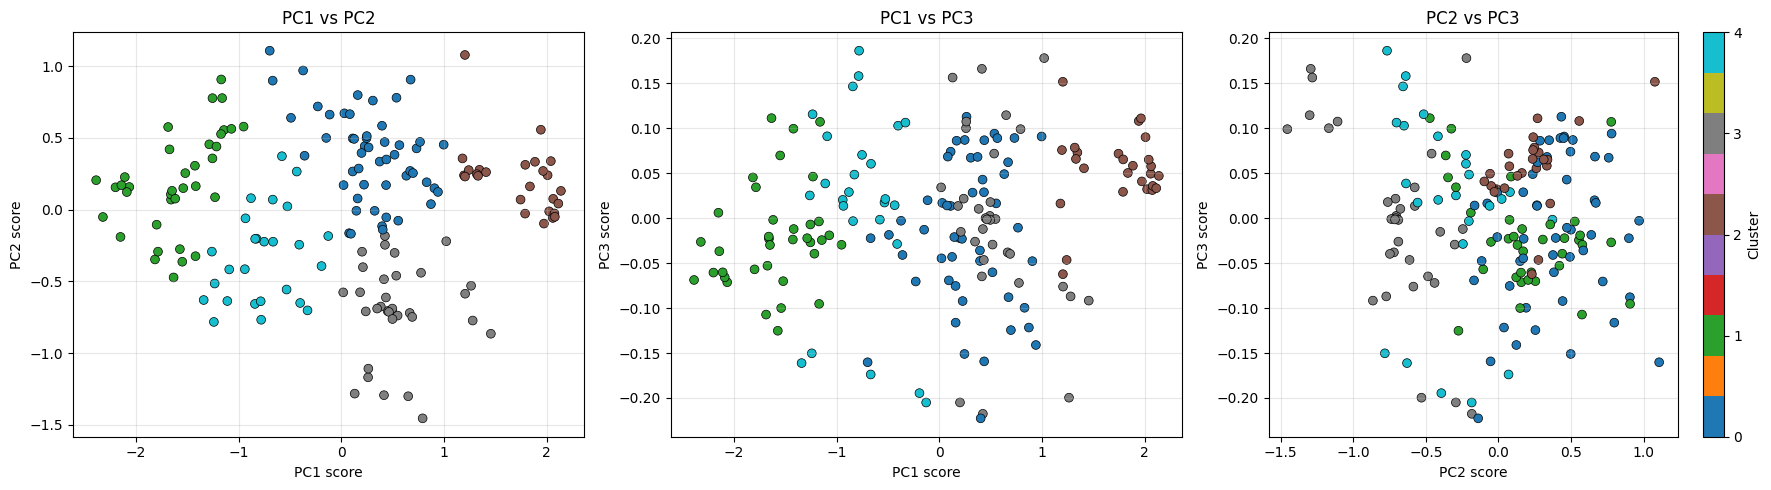

In [17]:
# Step 6b: Override cluster count and visualize
# Change k here and re-run this cell + cells below to explore different groupings
labels, best_k = override_clusters(scores, k=FORCE_K or best_k)
plot_score_scatter(scores, labels, n_components, best_k, OUTPUT_DIR, suffix=f"_k{best_k}")


### Step 7: Cluster inspection

In [18]:
# Step 7: Cluster inspection
centroids = plot_cluster_spectra(x_grid, matrix, names, labels, best_k, OUTPUT_DIR)


Saved: cluster_spectra.png
Saved: cluster_centroids.png


### Step 8: Outlier detection

In [19]:
# Step 8: Outlier / rare phase detection
outliers = find_outliers(scores, names, labels)



Potential outliers / rare phases (3 spectra):
  FeXANES_GT5_flaky2_FeXRD_10.001 (cluster 1, dist=1.085, threshold=1.048)
  FeXANES_GT5_flakysmooth2_Fe_22.001 (cluster 1, dist=1.232, threshold=1.048)
  FeXANES_GT15_super_dark_Fe_14.001 (cluster 3, dist=1.020, threshold=0.824)


### Step 9: Export results

In [20]:
# Step 9: Export results
df = export_results(names, labels, scores, n_components, outliers, OUTPUT_DIR)

# Summary
print(f"\nTotal spectra analyzed: {len(names)}")
print(f"PCA components: {n_components}")
print(f"Clusters: {best_k}")
for ci in range(best_k):
    print(f"  Cluster {ci+1}: {(labels == ci).sum()} spectra")
print(f"Outliers: {len(outliers)}")



Saved: pca_results/cluster_assignments.csv

Total spectra analyzed: 172
PCA components: 5
Clusters: 5
  Cluster 1: 51 spectra
  Cluster 2: 36 spectra
  Cluster 3: 26 spectra
  Cluster 4: 33 spectra
  Cluster 5: 26 spectra
Outliers: 3
